In [4]:
import numpy as np
import plotly.graph_objects as go
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import ticker, cm
from matplotlib import colors
from matplotlib import rcParams
from matplotlib.widgets import Slider, Button, RadioButtons
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from ipywidgets import interact
from decimal import Decimal
from libnirs import *
import math

In [5]:
#Run this only on Mac Local
%env PATH=/Library/TeX/texbin:$PATH
latex_path = '/usr/local/texlive/2023/bin/universal-darwin'

rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}\usepackage{{amsfonts}}\usepackage{{amssymb}}'
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['mathtext.fontset'] = 'cm'


env: PATH=/Library/TeX/texbin:$PATH


In [6]:
def regression(wav, y_in):
    A = np.vstack([wav, np.ones(len(wav))]).T
    m, c = np.linalg.lstsq(A,y_in, rcond=None)[0]
    y = (m*wav) + c
    
    return y, m, c

In [7]:
file_name ='Only_LRF_Preterm'

In [8]:
#with pd.ExcelFile(path) as xls:  
df_LRF = pd.read_excel(f"xlsx_files/{file_name}.xlsx")  

In [9]:
df_LRF.columns.values

array(['Subject ID', 'Group', 'Date', 'Stage', 'Device', 'mua673',
       'mua686', 'mua701', 'mua724', 'mua754', 'mua784', 'mua814',
       'mua827', 'musp673', 'musp686', 'musp701', 'musp724', 'musp754',
       'musp784', 'musp814', 'musp827', 'ma_852', 'ms_852'], dtype=object)

In [10]:
df_LRF=df_LRF.rename(columns={"ma_852": "mua852", "ms_852": "musp852"})

In [11]:
df_LRF=df_LRF.rename(columns={"ma_852": "mua852", "ms_852": "musp852"})
µa_dict = {}; µsp_dict = {}; 

wavelengths = ['673', '686', '701', '724', '754', '784', '814', '827', '852']

for wl in wavelengths:
    dfa = df_LRF['mua'+wl]; dfa = dfa.dropna(); µa_dict[wl] = dfa.to_numpy()
    dfsp = df_LRF['musp'+wl]; dfsp = dfsp.dropna(); µsp_dict[wl] = dfsp.to_numpy()

In [12]:
# This function takes the µ values and returns an array in which each position represents an interval and the corresponding value is the number
# of µ elements within that interval

def array_making(µ,interval_len,max_value): 
    
    max_bin_value = (max_value/interval_len)
    bin_classifying_µ = np.asarray(np.floor(µ/interval_len), int)
    return max_bin_value, bin_classifying_μ

def filling_hist(µ_a,µ_sp,interval_len_a,interval_len_sp, max_value_a, max_value_sp):
    #bin_classifying_a/sp are arrays that each element corresponds to a value of µ, the actual value is where they belong in the matrix
    
    max_bin_value_a, bin_classifying_a = array_making(µ_a, interval_len_a,max_value_a)
    max_bin_value_sp, bin_classifying_sp = array_making(µ_sp, interval_len_sp,max_value_sp)

    # filled_bins_µ is a matrix with the amount of bins of "sp" as rows and the amunt of "a" as columns                                                                              
    filled_bins_µ = np.zeros((int(max_bin_value_sp)+1,int(max_bin_value_a)+1))
    
    #print(max(bin_classifying_a)*interval_len_a)
    #print(max(bin_classifying_sp)*interval_len_sp)

    for µ_a_elem, µ_sp_elem  in zip(bin_classifying_a, bin_classifying_sp):
        filled_bins_µ[µ_sp_elem,µ_a_elem] = filled_bins_µ[µ_sp_elem,µ_a_elem] + 1
    
    tick_values_sp = np.round(np.arange(0,(max_bin_value_sp*interval_len_sp)+interval_len_sp, interval_len_sp),5)
    tick_values_a = np.round(np.arange(0,(max_bin_value_a*interval_len_a)+interval_len_a, interval_len_a ),3)

        
    return tick_values_a, tick_values_sp, filled_bins_µ



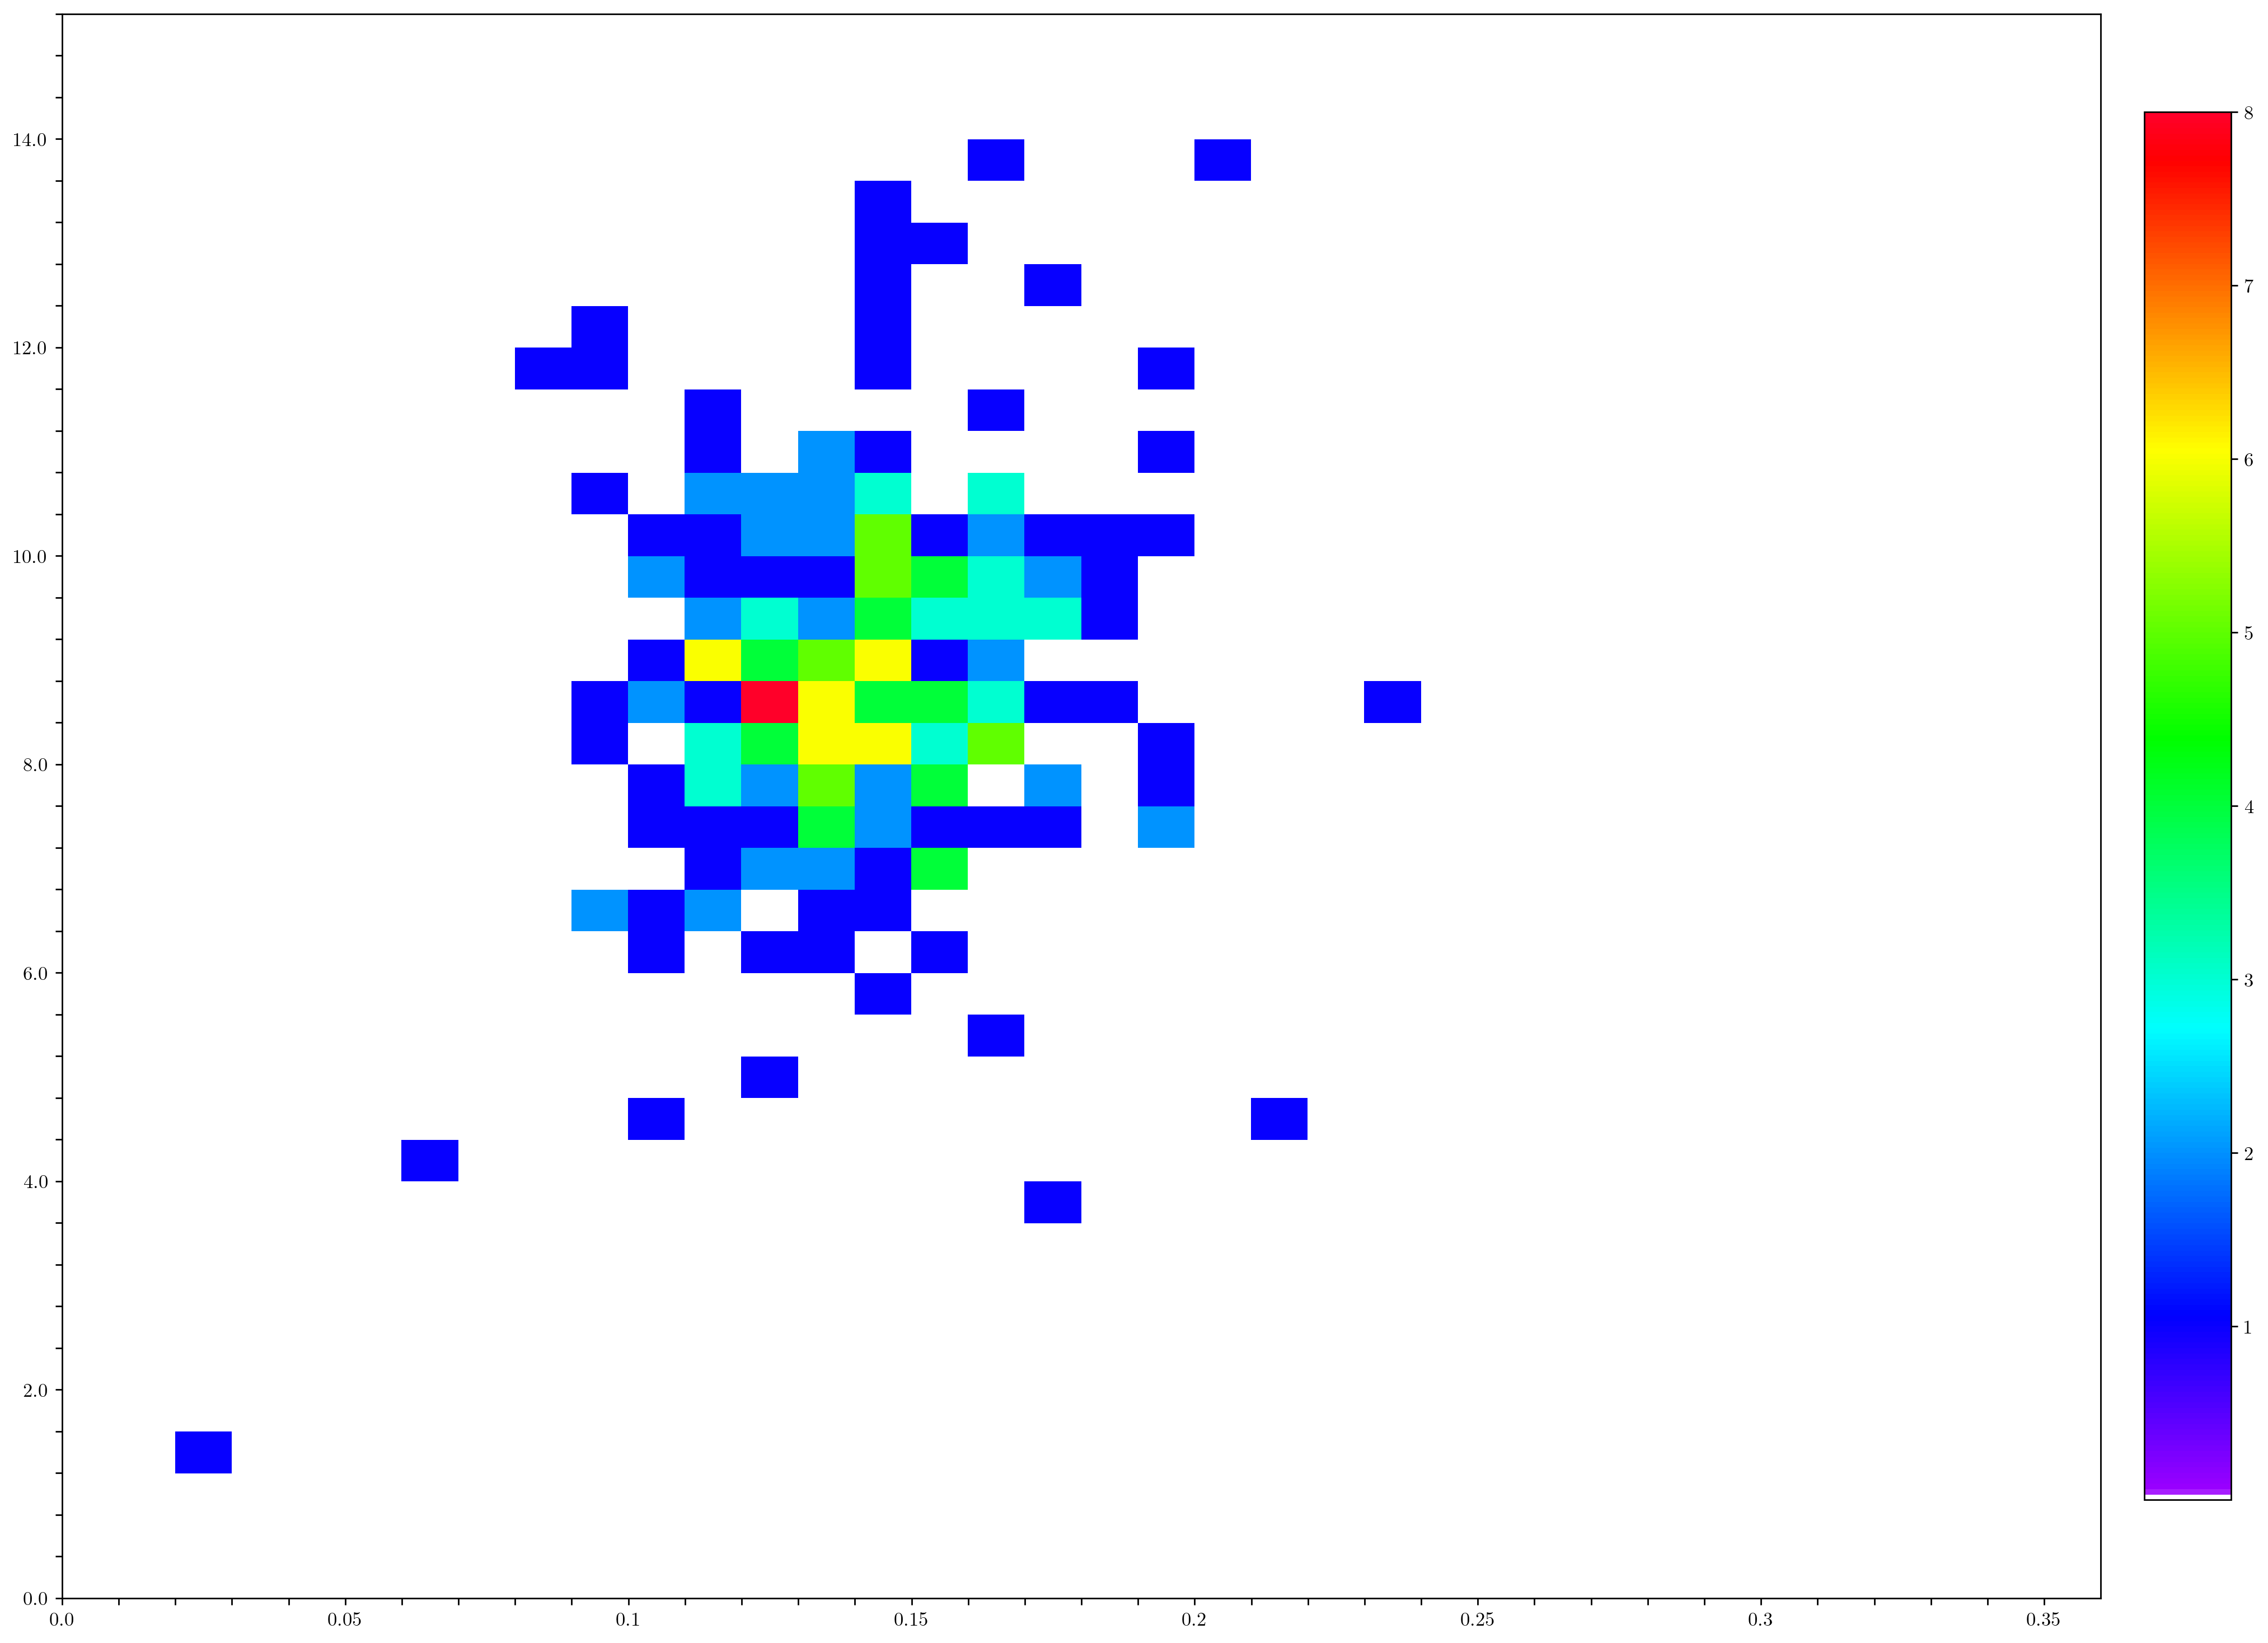

In [13]:
#ax, x_bin, y_bin,x_values,y_values,max_value_x,max_value_y,tick_val_x,tick_val_y
fig_µ, axµ = plt.subplots(figsize=(20,15),dpi=250)

#Design of graph
plasma_colormap = np.flipud(plt.cm.gist_rainbow(np.linspace(0, 1, 256)))
plasma_colormap = np.delete(plasma_colormap,np.arange(0,30),0)
white_colormap = np.array([[1, 1, 1, 1]])  # White color in RGBA format
custom_colormap = np.concatenate((white_colormap, plasma_colormap), axis=0)
cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colormap)
# x_values are µa_values obtained from the dictionary y is µsp 

#def filling_hist(µ_a,µ_sp,interval_len_a,interval_len_sp, max_value_a, max_value_sp):

#def plot_2d_hist(ax, x_bin, y_bin,x_values,y_values,max_value_x,max_value_y,tick_val_x,tick_val_y):

#x_tick_values, y_tick_values, filled_bins = filling_hist(x_values,y_values, x_bin,y_bin,max_value_x,max_value_y)

max_value_x = 0.35; max_value_y = 15

x_tick_values, y_tick_values, filled_bins = filling_hist(µa_dict['673'],µsp_dict['673'], 0.01,0.4,max_value_x,max_value_y)
#plot_2d_hist(axµ, 0.01, 0.4,x_values,y_values,0.35,15,0.5,1)

tick_val_y = 1; tick_val_x = 0.05
axµ.clear()
axµ.pcolor(filled_bins, cmap=cmap)
axµ.set_xticks(np.arange(len(x_tick_values)), labels=x_tick_values)
axµ.set_yticks(np.arange(len(y_tick_values)), labels=y_tick_values)
labels_of_interest_y =np.arange(0,15+tick_val_y,tick_val_y); labels_of_interest_x = np.arange(0,max_value_x+tick_val_x,tick_val_x)
if tick_val_y < 0.01:
    new_labels_y = ['%.2E' % Decimal(str(label)) if label in labels_of_interest_y else "" for label in y_tick_values]

else:
    new_labels_y = [label if label in labels_of_interest_y else "" for label in y_tick_values]

    
new_labels_x = [label if label in np.round(labels_of_interest_x,3) else "" for label in np.round(x_tick_values,3)]
axµ.set_yticklabels(new_labels_y); axµ.set_xticklabels(new_labels_x)

pcm = axµ.pcolor(filled_bins, cmap=cmap)
norm = plt.Normalize(vmin=1, vmax=pcm.get_array().max())
cbar = plt.colorbar(pcm, ax=axµ, orientation="vertical", ticks=np.arange(1, pcm.get_array().max() + 1),
                pad=0.02, fraction=0.04, aspect=16)
plt.draw()


In [43]:
def plot_2d_hist(ax, x_bin, y_bin,x_values,y_values,max_value_x,max_value_y,tick_val_x,tick_val_y,ax_fontsize_):
    plasma_colormap = np.flipud(plt.cm.gist_rainbow(np.linspace(0, 1, 256)))
    plasma_colormap = np.delete(plasma_colormap,np.arange(0,30),0)
    white_colormap = np.array([[1, 1, 1, 1]])  # White color in RGBA format
    custom_colormap = np.concatenate((white_colormap, plasma_colormap), axis=0)
    cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colormap)

    x_tick_values, y_tick_values, filled_bins = filling_hist(x_values,y_values, x_bin,y_bin,max_value_x,max_value_y)
    ax.clear()
    ax.pcolor(filled_bins, cmap=cmap)
    #ax.set_title(r'$\mathrm{Wavelength\ ' + str(wavelength) + '}$', fontsize=18, fontweight='bold', fontfamily='DejaVu Sans')
    ax.set_xticks(np.arange(len(x_tick_values)), labels=x_tick_values)
    ax.set_yticks(np.arange(len(y_tick_values)), labels=y_tick_values)

    #ax.set_xlabel(r"$\mathrm{µ_a(cm^{-1})}$", fontsize=18, fontweight='bold', fontfamily='DejaVu Sans')
    #ax.set_ylabel(r"$\mathrm{µ_s'(cm^{-1})}$", fontsize=18, fontweight='bold', fontfamily='DejaVu Sans')
    
    labels_of_interest_y =np.arange(0,max_value_y+tick_val_y,tick_val_y); labels_of_interest_x = np.arange(0,max_value_x+tick_val_x,tick_val_x)
    if tick_val_y < 0.01:
        new_labels_y = ['%.2E' % Decimal(str(label)) if label in labels_of_interest_y else "" for label in y_tick_values]

    else:
        new_labels_y = [label if label in np.round(labels_of_interest_y,3) else "" for label in y_tick_values]

        
    new_labels_x = [label if label in np.round(labels_of_interest_x,3) else "" for label in x_tick_values]
    ax.set_yticklabels(new_labels_y, size = ax_fontsize_); ax.set_xticklabels(new_labels_x, size = ax_fontsize_)
   
    
    pcm = ax.pcolor(filled_bins, cmap=cmap)
    norm = plt.Normalize(vmin=1, vmax=pcm.get_array().max())
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", ticks=np.arange(1, pcm.get_array().max() + 1),
                    pad=0.02, fraction=0.04, aspect=16)
    plt.draw()


In [15]:
"""
Saving different plots
for w in wavelengths:
    fig, ax = plt.subplots(figsize=(8, 11))
    plt.subplots_adjust(bottom=0.25)
    plot_2d_hist(ax, 0.01,0.4,w,0.35,15)
    plt.savefig('Hist_wl_IVH_LRF:'+str(w)+'.png')
    plt.close()
"""

"\nSaving different plots\nfor w in wavelengths:\n    fig, ax = plt.subplots(figsize=(8, 11))\n    plt.subplots_adjust(bottom=0.25)\n    plot_2d_hist(ax, 0.01,0.4,w,0.35,15)\n    plt.savefig('Hist_wl_IVH_LRF:'+str(w)+'.png')\n    plt.close()\n"

In [16]:
µa_range = np.linspace(0.01, 0.35,300)
µsp_range = np.linspace(0.01, 15, 300)
µa = np.outer(µa_range, np.ones(600))
µsp = np.outer(µsp_range, np.ones(600))

reflectance_matrix = np.empty((0,len(µa)),(float))

for µa_n in µa_range: 
    reflectance_array = []
    for µsp_n in µsp_range: 
        reflectance = model_ss(3, µa_n, µsp_n, 1.4, 1)
        reflectance_array = np.append(reflectance_array, abs(reflectance))
    reflectance_matrix = np.append(reflectance_matrix, [reflectance_array], axis =0)
[X, Y] = np.meshgrid(µa_range, µsp_range)  
Z = reflectance_matrix

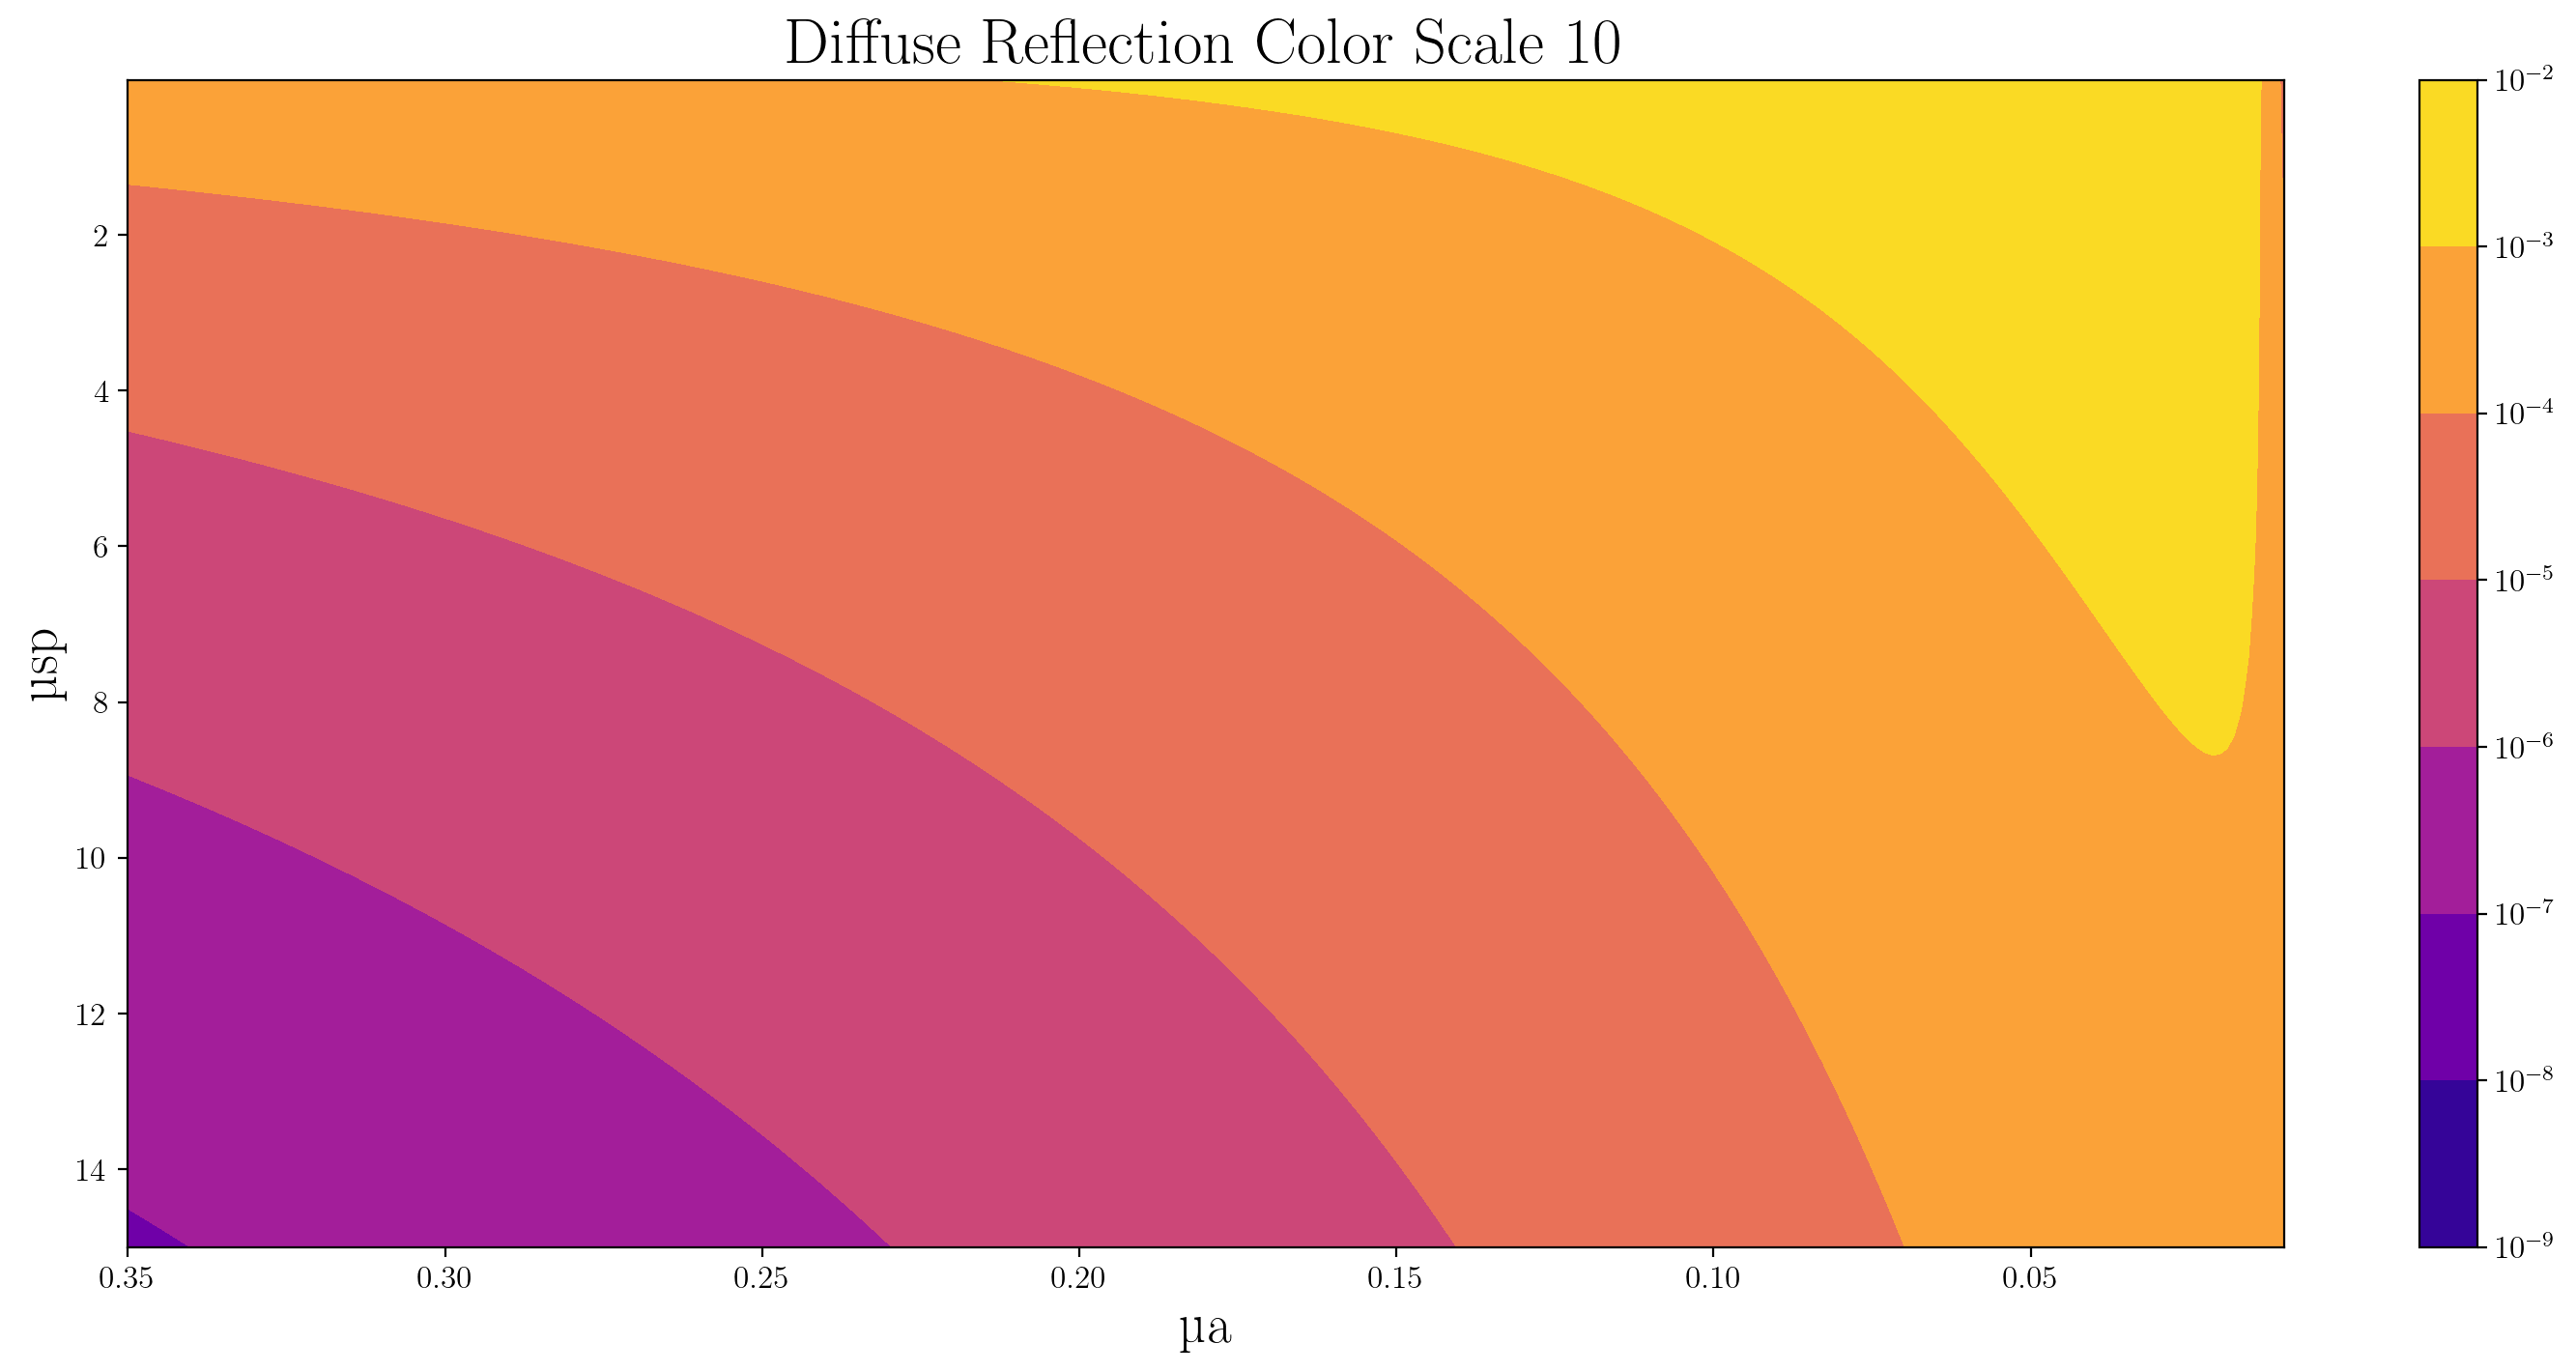

In [22]:
plt.close('all')
fig, ax = plt.subplots(figsize= (18,8),dpi = 200)
#cs = ax.contourf(X, Y, Z, locator=ticker.LogLocator(),cmap=plt.cm.PuRd)
log_scale = 10
lev_exp = np.arange(np.floor(math.log(Z.min(),log_scale)-1),
                    np.ceil(math.log(Z.max(),log_scale)+1))
levs = np.power(log_scale, lev_exp)
colorbar_ticks = ['%.1E' % Decimal(str(val)) for val in levs]
cs = ax.contourf(X, Y, Z, levs, norm=colors.LogNorm(), cmap=plt.cm.plasma)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

cbar = fig.colorbar(cs, ticks=levs) #ticklabels=colorbar_ticks)  # Set custom tick values
plt.xlabel("µa", fontsize=20) ; plt.ylabel("µsp", fontsize=20) 
plt.title("Diffuse Reflection Color Scale "+str(log_scale), fontsize=24);
plt.rcParams['figure.dpi']=500
plt.rcParams.update({'font.size': 12})

Text(0.5, 1.0, "$\\mu_s'$  $\\&$  $\\mu_a$ Histogram, Wavelength = 673")

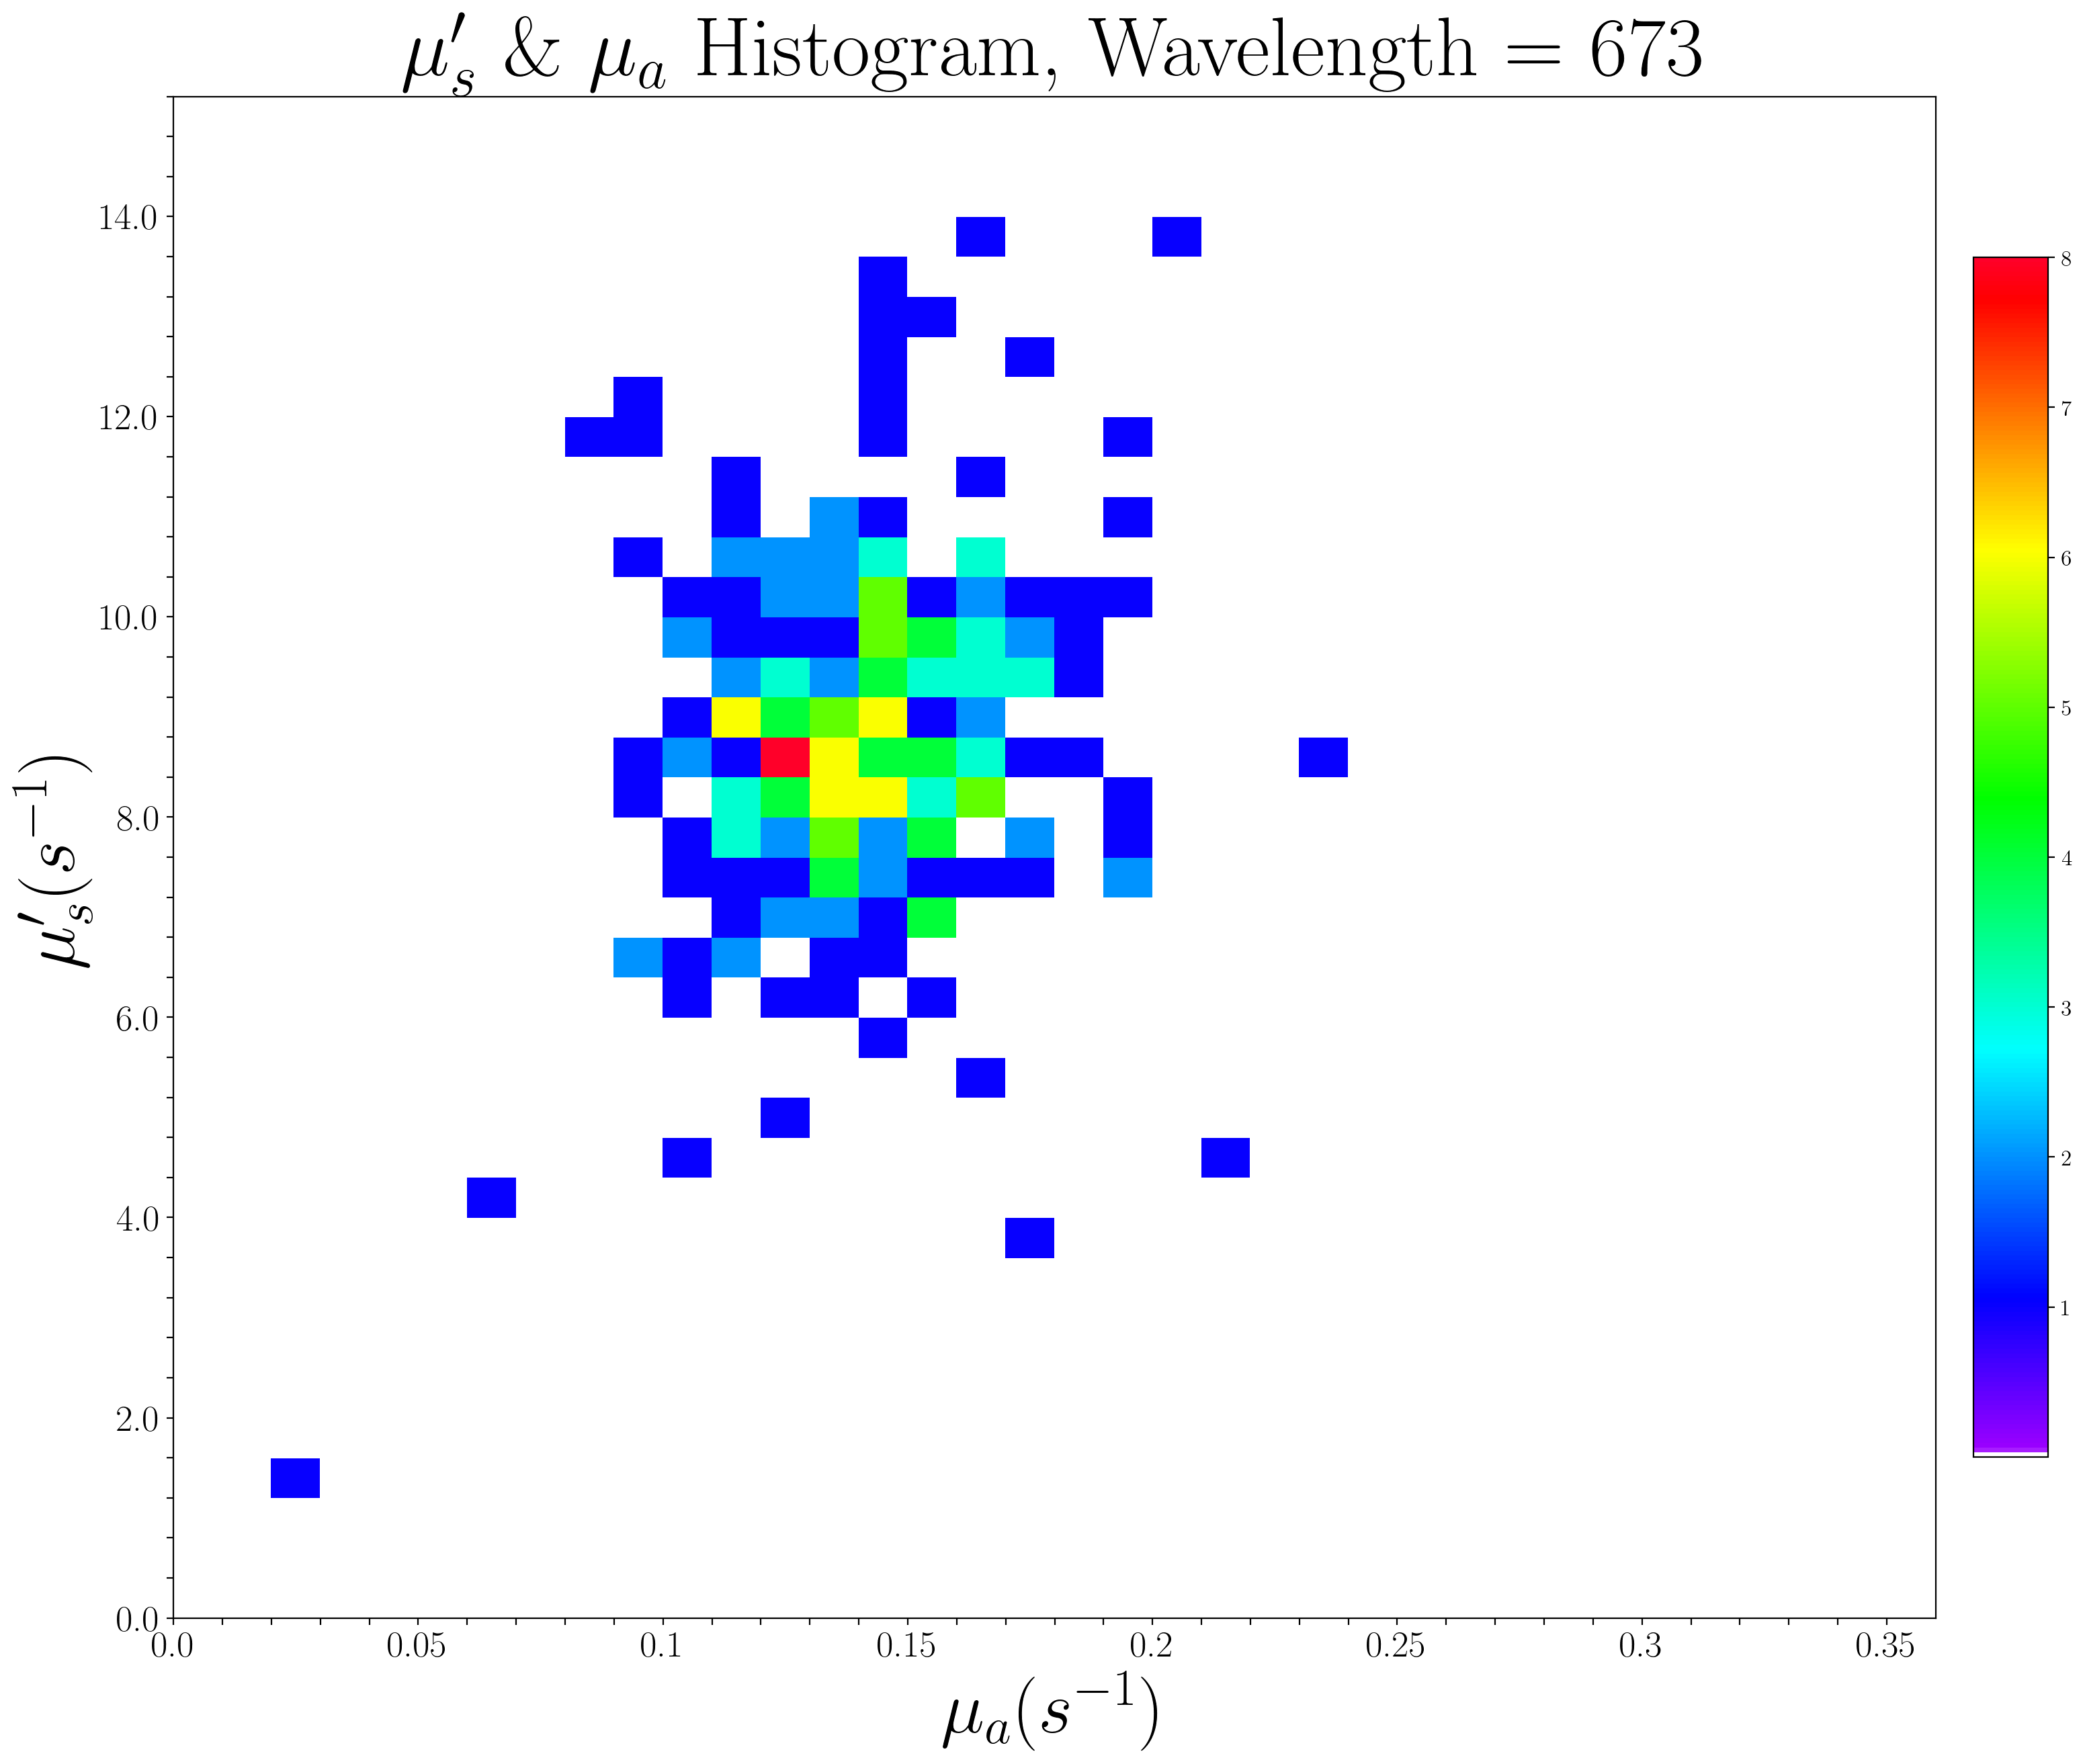

In [44]:
fig_µ, axµ = plt.subplots(figsize=(18,15),dpi = 200)
max_value_µa = 0.35; max_value_µsp = 15; µa_bin = 0.05; µsp_bin = 1
wl = '673'; ax_fontsize = 20
plot_2d_hist(axµ, 0.01, 0.4,µa_dict[wl],µsp_dict[wl],max_value_µa,max_value_µsp,µa_bin,µsp_bin, ax_fontsize)

axµ.set_xlabel(fr'$\mu_a (s^{{-1}})$',size=40)
axµ.set_ylabel(fr"$\mu_s' (s^{{-1}})$",size=40)
axµ.set_title(fr"$\mu_s'$  $\&$  $\mu_a$ Histogram, Wavelength = {wl}", size = 45)

env: PATH=/Library/TeX/texbin:$PATH
